In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

2023-04-29 19:14:28.787456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
np.random.seed(33)

In [3]:
wireplane = "Z"
path = 'processed_data/'
filenames = [path+f for f in listdir(path) if (isfile(join(path, f)) and wireplane in f)]
filenames

['processed_data/y_test_ROI_Z.npy',
 'processed_data/y_test_AE_Z.npy',
 'processed_data/x_test_Z.npy',
 'processed_data/y_train_ROI_Z.npy',
 'processed_data/x_train_Z.npy',
 'processed_data/y_train_AE_Z.npy']

In [44]:
x_train = np.load(path+'x_train_' + wireplane + '.npy')
x_test = np.load(path+'x_test_' + wireplane + '.npy')
y_train = np.load(path+'y_train_ROI_' + wireplane + '.npy')
y_test = np.load(path+'y_test_ROI_'+wireplane+'.npy')

In [5]:
print(x_test.shape, y_train.shape, y_test.shape, y_train.shape)

(100000, 200) (100000,) (100000,) (100000,)


In [6]:
#split train and valid sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=True
)

In [7]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

(80000, 200) (80000,)
(100000, 200) (100000,)
(20000, 200) (20000,)


In [8]:
mean = x_train.mean()
std = x_train.std()

In [9]:
x_train_scaled = (x_train-mean)/std
x_valid_scaled = (x_valid-mean)/std
x_test_scaled = (x_test-mean)/std

In [10]:
np.save("ROI_models/mean_"+wireplane+"_nu_ROI", mean)
np.save("ROI_models/scale_"+wireplane+"_nu_ROI", std)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, \
    Dropout, Dense,Flatten, AveragePooling1D, BatchNormalization

In [12]:
time_periods = 200
def create_model():
    model = Sequential()  
    #first convolutional block
    model.add(Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", input_shape=(time_periods,1)))
    model.add(MaxPooling1D(pool_size=2))

    #second convolutional block
    model.add(Conv1D(filters=32, kernel_size=5, strides=2, activation = "relu"))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))

    #forth convolutional block                                      
    model.add(Conv1D(filters=64, kernel_size=9, activation = "relu"))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2)) 

    model.add(Flatten())



    model.add(Dense(1, activation="sigmoid", name="wavrec_out"))
    return model

In [13]:
model = create_model()

#lr=0.001
adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

2023-04-29 19:14:30.858362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-29 19:14:30.863246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-29 19:14:30.863571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-29 19:14:30.864172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 99, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 32)            2592      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 64)             1

In [14]:
x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0], x_valid_scaled.shape[1], 1)
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

In [15]:
print(x_train_scaled.shape, x_valid_scaled.shape, x_test_scaled.shape)

(80000, 200, 1) (20000, 200, 1) (100000, 200, 1)


In [16]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [17]:
#%%time
history = model.fit(x_train_scaled,                                                              
                    y_train,                                                            
                    batch_size=2048,                                              
                    epochs=100,      
                    
                   # epochs=30, 
                    #epochs = 6,
                    callbacks=[earlystop],
                     # callbacks=callbacks_list,                         
                    validation_data=(x_valid_scaled, y_valid),                                               
                    verbose=1)   

Epoch 1/100


2023-04-29 19:14:32.962439: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-04-29 19:14:34.329973: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-04-29 19:14:34.517452: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-29 19:14:34.667355: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


40/40 [==============================] - 4s 23ms/step - loss: 0.5308 - accuracy: 0.7374 - val_loss: 0.4368 - val_accuracy: 0.7959
Epoch 2/100
40/40 [==============================] - 0s 8ms/step - loss: 0.4030 - accuracy: 0.8155 - val_loss: 0.3743 - val_accuracy: 0.8339
Epoch 3/100
40/40 [==============================] - 0s 7ms/step - loss: 0.3618 - accuracy: 0.8412 - val_loss: 0.3510 - val_accuracy: 0.8457
Epoch 4/100
40/40 [==============================] - 0s 8ms/step - loss: 0.3463 - accuracy: 0.8508 - val_loss: 0.3425 - val_accuracy: 0.8526
Epoch 5/100
40/40 [==============================] - 0s 8ms/step - loss: 0.3401 - accuracy: 0.8540 - val_loss: 0.3388 - val_accuracy: 0.8550
Epoch 6/100
40/40 [==============================] - 0s 8ms/step - loss: 0.3366 - accuracy: 0.8558 - val_loss: 0.3373 - val_accuracy: 0.8565
Epoch 7/100
40/40 [==============================] - 0s 8ms/step - loss: 0.3352 - accuracy: 0.8572 - val_loss: 0.3356 - val_accuracy: 0.8571
Epoch 8/100
40/40 [=====

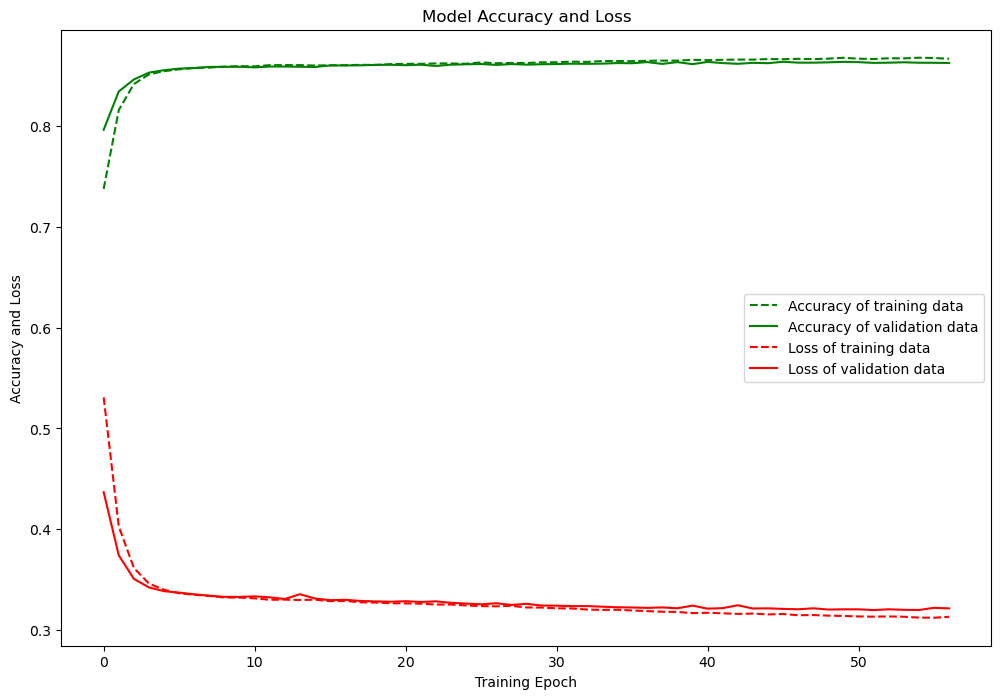

In [18]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data", antialiased=True)
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data", antialiased=True)
plt.plot(history.history['loss'], "r--", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "r", label="Loss of validation data", antialiased=True)
plt.title('Model Accuracy and Loss')                                            
plt.ylabel('Accuracy and Loss')                                                 
plt.xlabel('Training Epoch')                                                    
#plt.ylim(0)                                                                     
plt.legend()                                                                    
plt.show()     

In [19]:
#del x_train

import gc
gc.collect()

4006

In [20]:
model.save("ROI_models/model_" + wireplane + "plane_nu_ROI.h5")

In [21]:
model.evaluate(x_test_scaled, y_test, batch_size=4096)

25/25 [==============================] - 0s 10ms/step - loss: 28.7038 - accuracy: 0.5026


[28.703800201416016, 0.5025699734687805]

In [22]:
x_train_ = x_train_scaled
y_train_ = y_train

x_valid_ = x_valid_scaled
y_valid_ = y_valid


# Train

In [23]:
%%time
%matplotlib inline
import seaborn as sns
infer = model.predict(x_train_, batch_size=1024)

79/79 [==============================] - 0s 1ms/step
CPU times: user 532 ms, sys: 294 ms, total: 825 ms
Wall time: 803 ms


<Axes: >

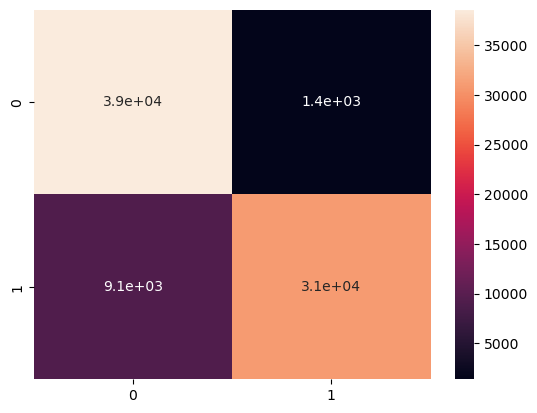

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_, infer>0.5)
sns.heatmap(cm, annot=True)

<Axes: >

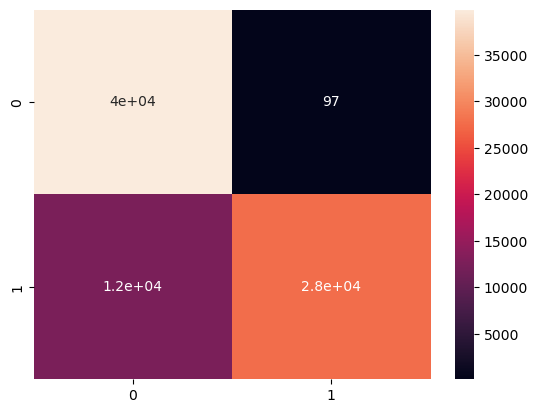

In [25]:
cm2 = confusion_matrix(y_train_, infer>0.9)
sns.heatmap(cm2, annot=True)

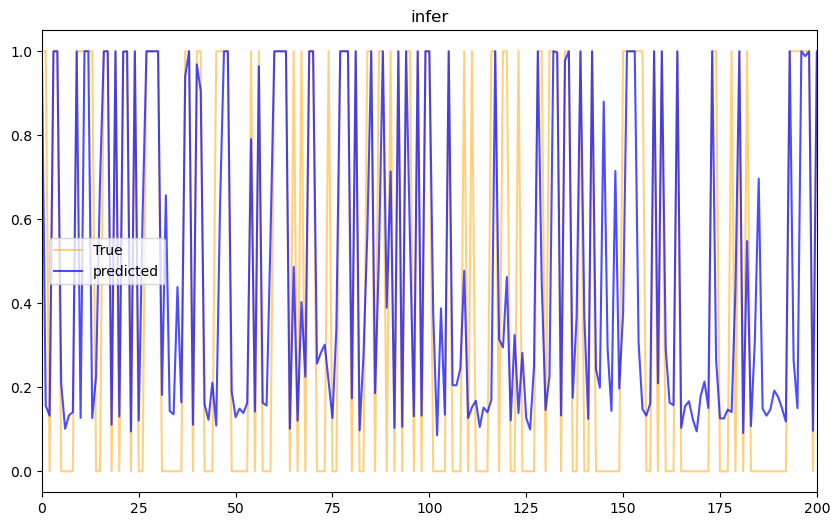

In [26]:
start_for_plot = 0
fig = plt.figure(figsize=(10,6))
plt.plot(y_train,color='orange',alpha=0.5, label='True')
plt.plot(infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train_, infer)
auc_keras = auc(fpr_keras, tpr_keras)

In [28]:
print(auc_keras)

0.9208747670545564


In [29]:
np.save("ROI_results/false_positive_" + wireplane + "_train", fpr_keras)
np.save("ROI_results/true_positive_" + wireplane + "_train", tpr_keras)
np.save("ROI_results/thresholds_" + wireplane + "_train", thresholds_keras)

# Valid

In [45]:
%%time
infer = model.predict(x_valid_, batch_size=4096)

5/5 [==============================] - 0s 3ms/step
CPU times: user 79.9 ms, sys: 33 ms, total: 113 ms
Wall time: 83.9 ms


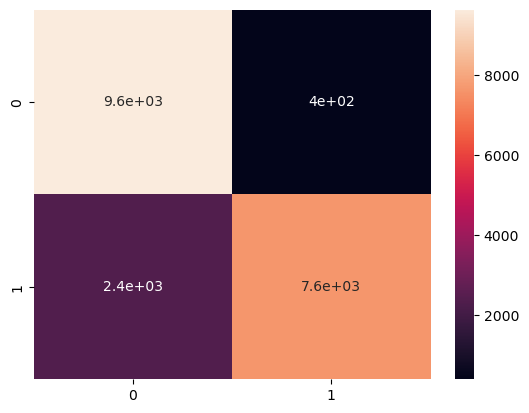

In [31]:
cmv = confusion_matrix(y_valid_, infer>0.5)
sns.heatmap(cmv, annot=True)
plt.show()

<Axes: >

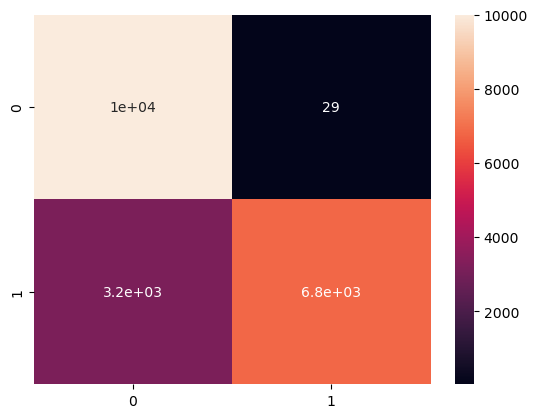

In [32]:
cmv2 = confusion_matrix(y_valid_, infer>0.9)
sns.heatmap(cmv2, annot=True)

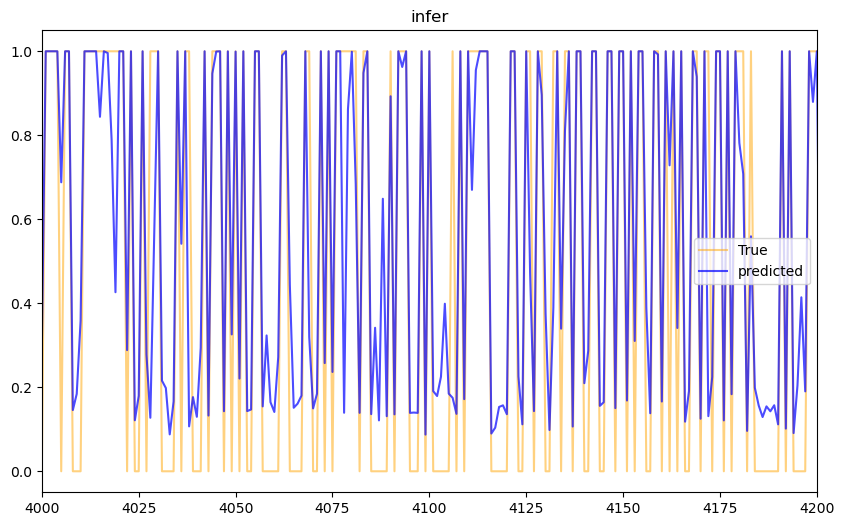

In [33]:
start_for_plot = 4000
fig = plt.figure(figsize=(10,6))
plt.plot(y_valid_,color='orange',alpha=0.5, label='True')
plt.plot(infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

In [34]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_valid_, infer)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

0.9128663407970672


In [35]:
np.save("ROI_results/false_positive_" + wireplane + "_valid", fpr_keras)
np.save("ROI_results/true_positive_" + wireplane + "_valid", tpr_keras)
np.save("ROI_results/thresholds_" + wireplane + "_valid", thresholds_keras)

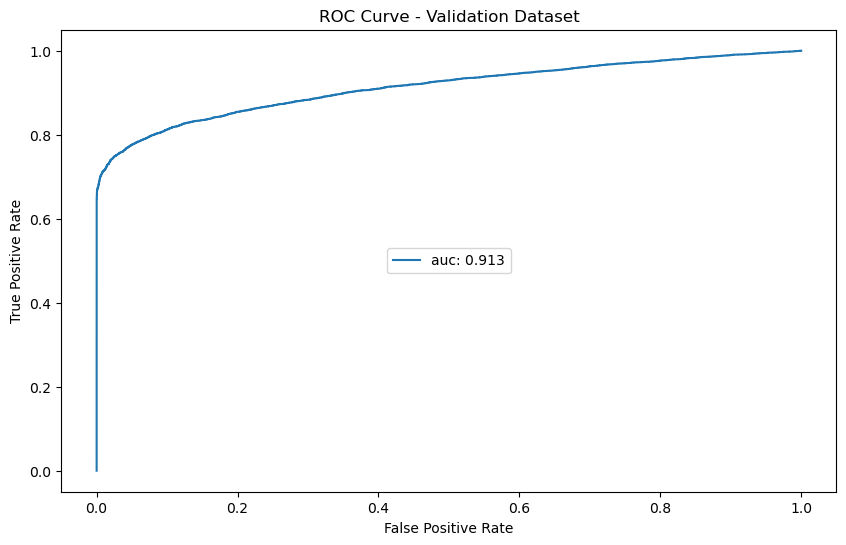

In [36]:
fig = plt.figure(figsize=(10,6))
plt.plot(fpr_keras, tpr_keras, label='auc: ' + str(round(auc_keras,3)))
plt.title("ROC Curve - Validation Dataset")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='center')
plt.show()

# test

In [46]:
#%%time
all_infer = model.predict(x_test_scaled, batch_size=4096)
all_y_test = y_test


25/25 [==============================] - 0s 4ms/step


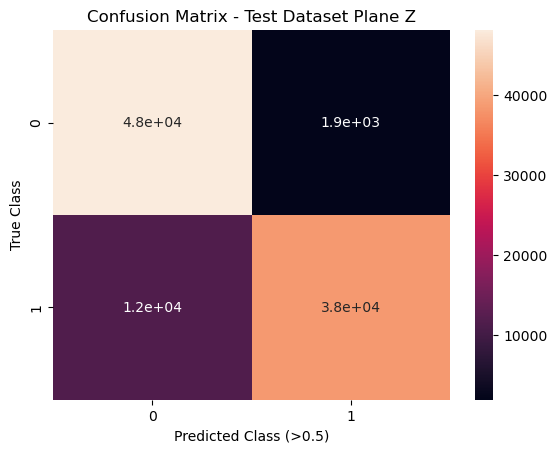

In [47]:
all1 = confusion_matrix(all_y_test, all_infer>0.5)
sns.heatmap(all1, annot=True)
plt.title("Confusion Matrix - Test Dataset Plane " + wireplane)
plt.xlabel("Predicted Class (>0.5)")
plt.ylabel("True Class")
plt.show()

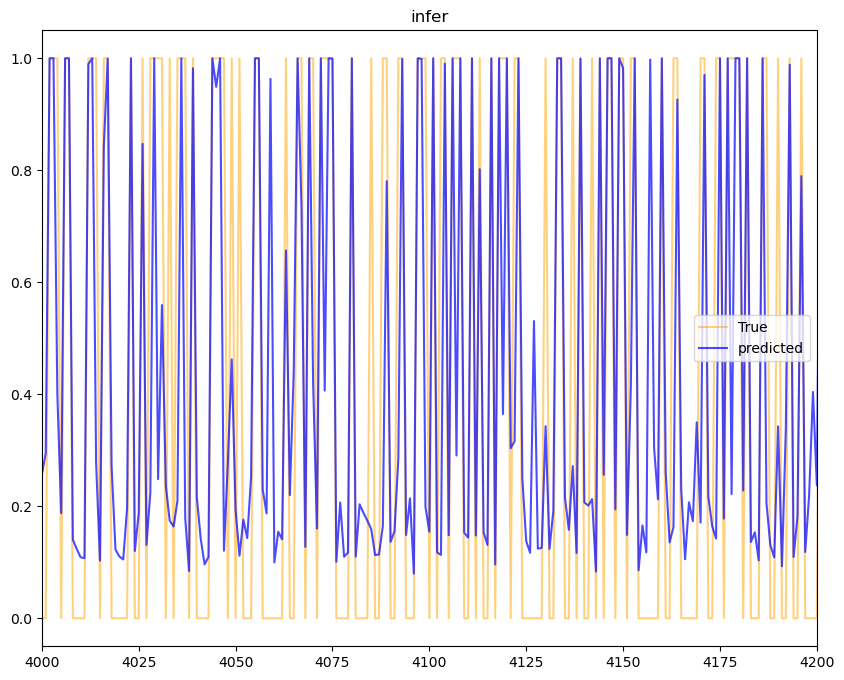

In [48]:
start_for_plot = 4000
fig = plt.figure(figsize=(10, 8))
plt.plot(all_y_test,color='orange',alpha=0.5, label='True')
plt.plot(all_infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

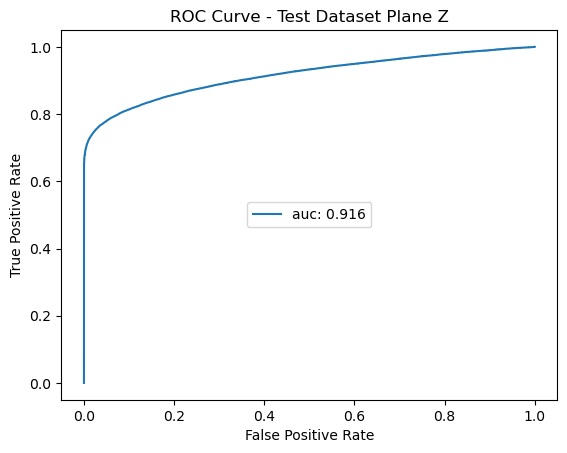

In [49]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(all_y_test, all_infer)
plt.plot(fpr_keras, tpr_keras, label='auc: ' + str(round(auc(fpr_keras, tpr_keras), 3)))
plt.title("ROC Curve - Test Dataset Plane " + wireplane )
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='center')
plt.show()

In [50]:
%%time
#cc_infer_signal = model.predict(cc_x_test_scaled[cc_y_test==1], batch_size=4096)
#cc_infer_noise = model.predict(cc_x_test_scaled[cc_y_test==0], batch_size=4096)
#es_infer_signal = model.predict(es_x_test_scaled[es_y_test==1], batch_size=4096)
#es_infer_noise = model.predict(es_x_test_scaled[es_y_test==0], batch_size=4096)
all_infer_signal = model.predict(x_test_scaled[y_test==1], batch_size=4096)
all_infer_noise = model.predict(x_test_scaled[y_test==0], batch_size=4096)

13/13 [==============================] - 0s 3ms/step
CPU times: user 280 ms, sys: 172 ms, total: 452 ms
Wall time: 336 ms


(array([    0.,  3511., 19463., 12266.,  5604.,  2923.,  1812.,  1129.,
          822.,   585.,   412.,   318.,   242.,   224.,   185.,   135.,
          111.,   101.,   100.,    57.]),
 array([0.        , 0.05      , 0.1       , 0.15000001, 0.2       ,
        0.25      , 0.30000001, 0.34999999, 0.40000001, 0.44999999,
        0.5       , 0.55000001, 0.60000002, 0.64999998, 0.69999999,
        0.75      , 0.80000001, 0.85000002, 0.89999998, 0.94999999,
        1.        ]),
 <BarContainer object of 20 artists>)

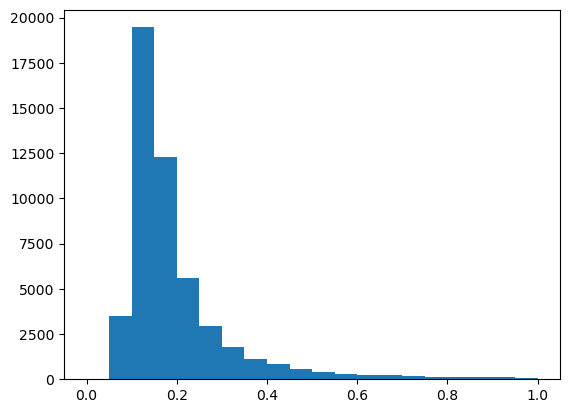

In [51]:
plt.hist(all_infer_noise, range = (0,1), bins=20)

(array([    0.,   319.,  2666.,  2640.,  1767.,  1296.,   910.,   777.,
          667.,   544.,   532.,   452.,   419.,   456.,   415.,   494.,
          493.,   622.,   829., 33702.]),
 array([0.        , 0.05      , 0.1       , 0.15000001, 0.2       ,
        0.25      , 0.30000001, 0.34999999, 0.40000001, 0.44999999,
        0.5       , 0.55000001, 0.60000002, 0.64999998, 0.69999999,
        0.75      , 0.80000001, 0.85000002, 0.89999998, 0.94999999,
        1.        ]),
 <BarContainer object of 20 artists>)

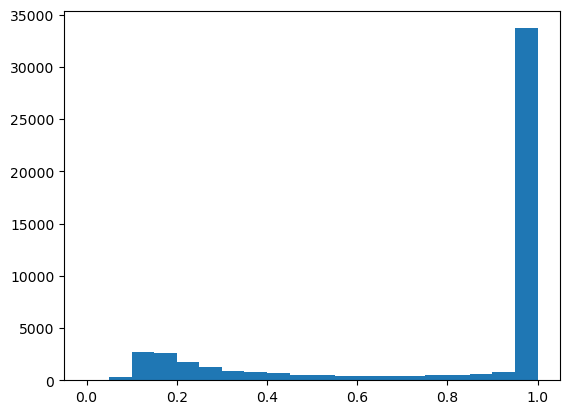

In [52]:
plt.hist(all_infer_signal, range = (0,1), bins=20)